In [2]:
%matplotlib inline
import os, glob,cv2, gc
import openslide
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [3]:
os.listdir('../data/input')

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_images',
 'train_label_masks']

In [4]:
data_dir = '../data/input'
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [5]:
train.head()

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

In [6]:
temp = train[train['data_provider'] == 'radboud']
temp = temp[temp['isup_grade'] != 0]

temp.head(20)

image_id data_provider  isup_grade gleason_score
2   0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
12  004dd32d9cd167d9cc31c13b704498af       radboud           1           3+3
15  0068d4c7529e34fd4c9da863ce01a161       radboud           3           4+3
17  006f6aa35a78965c92fffd1fbd53a058       radboud           3           4+3
19  0076bcb66e46fb485f5ba432b9a1fe8a       radboud           3           4+3
20  008069b542b0439ed69b194674051964       radboud           4           4+4
22  00928370e2dfeb8a507667ef1d4efcbb       radboud           5           4+5
23  00951a7fad040bf7e90f32e81fc0746f       radboud           1           3+3
24  00a26aaa82c959624d90dfb69fcf259c       radboud           4           4+4
26  00a7fb880dc12c5de82df39b30533da9       radboud           3           4+3
28  00bbc1482301d16de3ff63238cfd0b34       radboud           2           3+4
29  00c15b23b30a5ba061358d9641118904       radboud           5           4+5
30  00c46b336b5b06423fcdec1b4d5bee06       radboud           1           3+3
31  00c52cb4db1c7a5811a8f070a910c038       radboud           5           4+5
32  00ca0c23961b5510be46c917be11c43e       radboud           5           5+4
34  00d8a8c04886379e266406fdeff81c45       radboud           5           4+5
35  00e6511435645e50673991768a713c66       radboud           1           3+3
36  00ed4dbf9af6cc102e04cc9a42b313e2       radboud           1           3+3
38  00f6ea010b008e7b3635910a13b165a5       radboud           1           3+3
41  010670e9572e67e5a7e00fb791a343ef       radboud           5           4+5

In [7]:
def display_img(img_id, show_img=False, tiff_level=-1):
    img_path = os.path.join(data_dir, 'train_images', f'{img_id}.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        patch = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        patch = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    if show_img:
        display(patch)
        
    # PIL -> ndarray
    patch = np.asarray(patch)
    # RGBA -> RGB
    if patch.shape[-1] == 4:
        patch = patch[:, :, :3]
        
    slide.close()
    
    return patch


def display_mask(img_id, center, show_img=False, tiff_level=-1):
    assert center in ['radboud', 'karolinska'], "Please Set center=['radboud', 'karolinska']"
    
    img_path = os.path.join(data_dir, 'train_label_masks', f'{img_id}_mask.tiff')
    # Using Openslide
    slide = openslide.OpenSlide(img_path)
    # Set Properties  1: Point   2: Tiff Level   3: Viewing Dimension
    # .level_count -> Get Tiff Level Count
    # .level_dimensions -> Get Tiff Width, Height per Level
    if tiff_level == -1:
        mask_data = slide.read_region((0, 0), slide.level_count - 1, slide.level_dimensions[-1])
    else:
        mask_data = slide.read_region((0, 0), tiff_level, slide.level_dimensions[tiff_level])
    
    mask_data = mask_data.split()[0]
    # To show the masks we map the raw label values to RGB values
    preview_palette = np.zeros(shape=768, dtype=int)
    if center == 'radboud':
        # Mapping: {0: background(黒), 1: stroma(灰色), 2: benign epithelium(緑), 3: Gleason 3(淡黄色), 4: Gleason 4(オレンジ), 5: Gleason 5(赤)}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign(灰色), 2: cancer(赤色)}
        preview_palette[0:9] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 1, 0, 0]) * 255).astype(int)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_data = mask_data.convert(mode='RGB')
    if show_img:
        display(mask_data)
        
    # PIL -> ndarray
    mask_data = np.asarray(mask_data)
    # RGBA -> RGB
    if mask_data.shape[-1] == 4:
        mask_data = mask_data[:, :, :3]
        
    slide.close()
    
    return mask_data

In [8]:
def PANDA_Image_Preprocessing(target_id, SIZE=128, background_rate=0.5, save_dir='.', saveimg=True):
    """
    画像の読み込み＆前処理＆保存
    指定した画像サイズに応じてパディングを行い分割する
    分割した中のマスク（gleason_score）の割合を計算する
    
    """
    res = pd.DataFrame()

    img = display_img(target_id, show_img=False, tiff_level=0)
    mask = display_mask(target_id, 'radboud', show_img=False, tiff_level=0)

    # Padding
    H, W = img.shape[:2]
    pad_h = (SIZE - H % SIZE) % SIZE
    pad_w = (SIZE - W % SIZE) % SIZE

    padded_img = np.pad(
        img,
        pad_width=[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=255
    )

    padded_mask = np.pad(
        mask,
        pad_width=[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2, pad_w - pad_w // 2], [0, 0]],
        constant_values=0
    )

    new_H, new_W = padded_img.shape[:2]
    
    del img, mask
    gc.collect()

    for h in range(int(new_H / SIZE)):
        for w in range(int(new_W / SIZE)):

            _mask = padded_mask[h * SIZE:(h + 1) * SIZE, w * SIZE:(w + 1) * SIZE, :]
            _mask = np.sum(_mask, axis=2)

            # 0: 背景
            # 1: stroma(灰色)  = 153
            _mask = np.where(_mask==153, 0, _mask)
            # 2: benign epithelium(緑)  = 306
            _mask = np.where(_mask==306, 0, _mask)
            # 3: Gleason 3(淡黄色)  255, 255, 178 = = 688  score=3
            _mask = np.where(_mask==688, 3, _mask)
            # 4: Gleason 4(オレンジ)   255, 127, 0 = 382   score=4
            _mask = np.where(_mask==382, 4, _mask)
            # 5: Gleason 5(赤)   255, 0, 0 = (255 * 1.0 = 255)   score=5
            _mask = np.where(_mask==255, 5, _mask)

            u, counts = np.unique(_mask, return_counts=True)
            _dict = {f'score_{k}':[v] for k, v in zip(u, counts)}

            for score in ['score_0', 'score_3', 'score_4', 'score_5']:
                if score not in _dict:
                    _dict[score] = [0]

            _dict['image_id'] = [target_id + f'_{h}_{w}']  # グリッドのインデックスをファイル名に付与
            _res = pd.DataFrame(_dict)

            res = pd.concat([res, _res], axis=0, ignore_index=True)

    # 割合を計算（1グリッドごとの全ピクセルで除算）
    res['score_0'] = res['score_0'] / (SIZE * SIZE)
    res['score_3'] = res['score_3'] / (SIZE * SIZE)
    res['score_4'] = res['score_4'] / (SIZE * SIZE)
    res['score_5'] = res['score_5'] / (SIZE * SIZE)

    # 背景が多い画像は対象外とする
    _res = res[res['score_0'] < background_rate].reset_index(drop=True)

    img_list = []
    mask_list = []

    for i in range(len(_res)):
        image_id = _res['image_id'].loc[i]
        save_img_h = int(image_id.split('_')[1])
        save_img_w = int(image_id.split('_')[2])
        # 画像をトリミングしリストに保存
        _img = padded_img[save_img_h * SIZE:(save_img_h + 1) * SIZE, save_img_w * SIZE:(save_img_w + 1) * SIZE, :]
        _mask = padded_mask[save_img_h * SIZE:(save_img_h + 1) * SIZE, save_img_w * SIZE:(save_img_w + 1) * SIZE, :]
        img_list.append(_img)
        mask_list.append(_mask)
        
        if saveimg:
            _img = Image.fromarray(_img)
            _img.save(os.path.join(save_dir, image_id + '.jpg'))
        
    return res, img_list, mask_list

---
## Gleason_Score: 3+3

In [9]:
%%time
# gleason_score: "3+3"
target_id = '00e6511435645e50673991768a713c66'
SIZE = 128

res, img_list, mask_list = PANDA_Image_Preprocessing(target_id, SIZE, background_rate=0.5, saveimg=False)

Wall time: 1min 31s


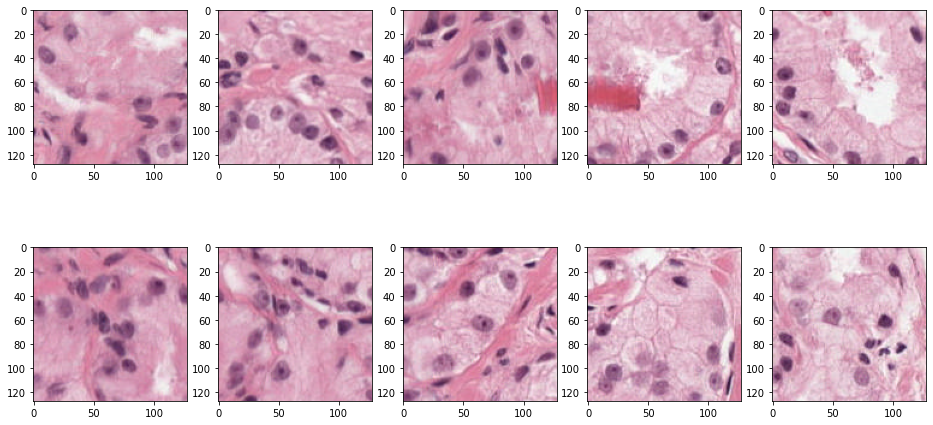

In [10]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)

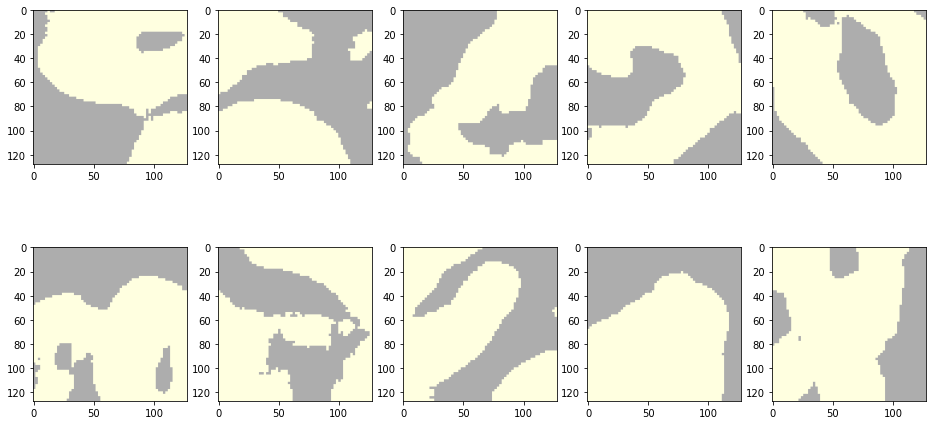

In [11]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(mask, alpha=0.4)

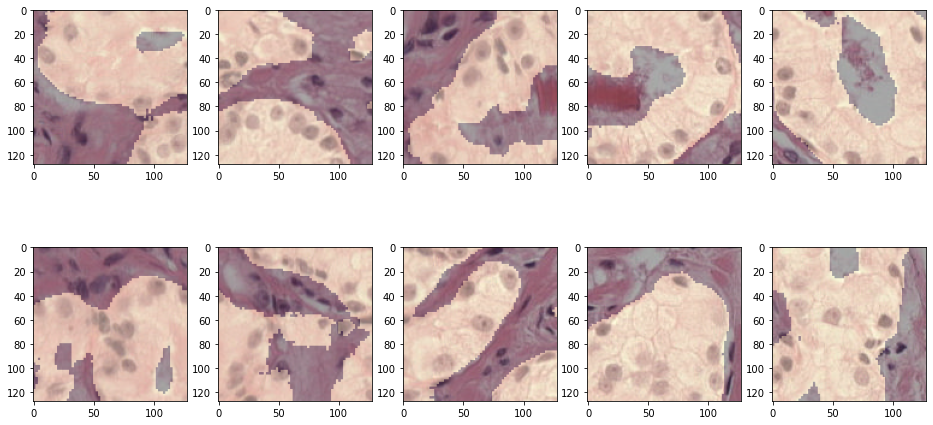

In [12]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)
    ax.imshow(mask, alpha=0.4)

---
## Gleason_Score: 4+4

In [13]:
%%time
target_id = '0018ae58b01bdadc8e347995b69f99aa'
SIZE = 128

res, img_list, mask_list = PANDA_Image_Preprocessing(target_id, SIZE, background_rate=0.5, saveimg=False)

Wall time: 31.2 s


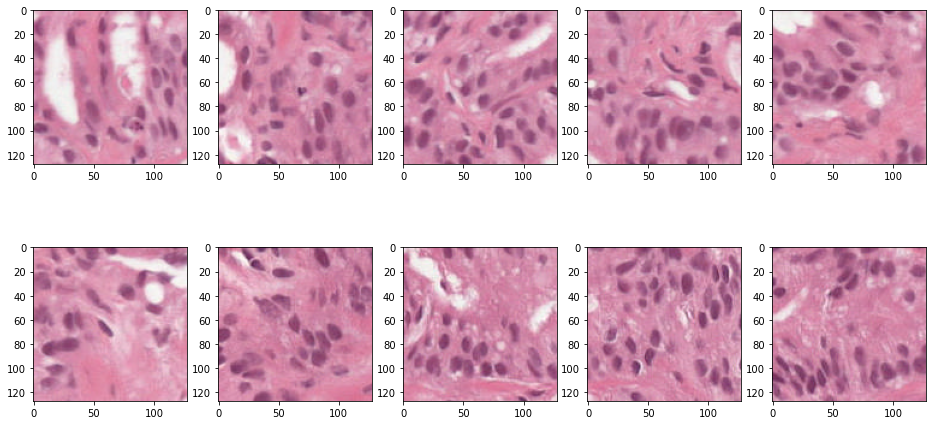

In [14]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)

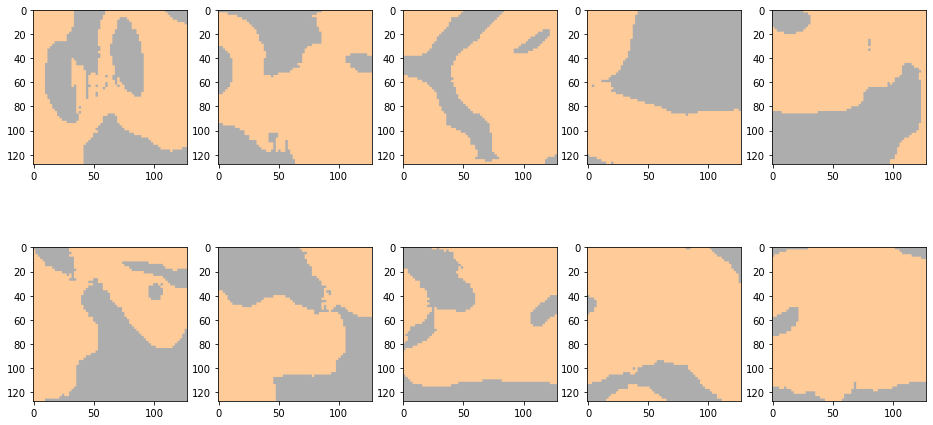

In [15]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(mask, alpha=0.4)

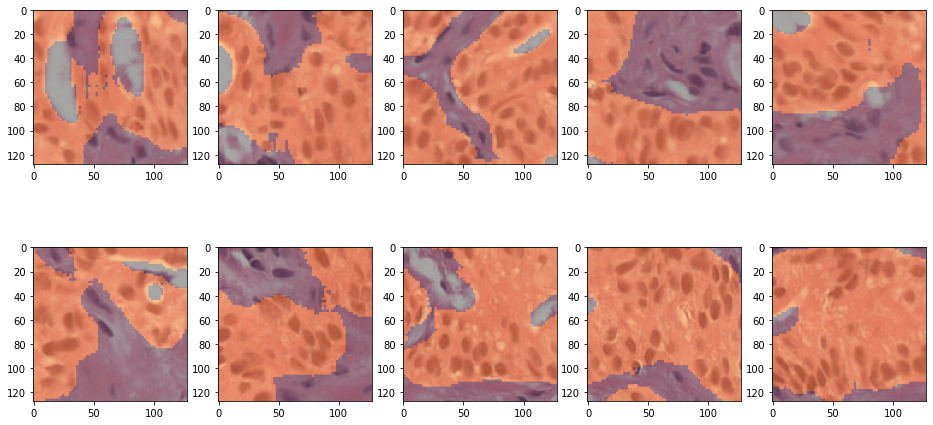

In [16]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)
    ax.imshow(mask, alpha=0.4)

---
## Gleason_Score: 4+3

In [17]:
%%time
target_id = '0076bcb66e46fb485f5ba432b9a1fe8a'
SIZE = 128

res, img_list, mask_list = PANDA_Image_Preprocessing(target_id, SIZE, background_rate=0.5, saveimg=False)

Wall time: 34.5 s


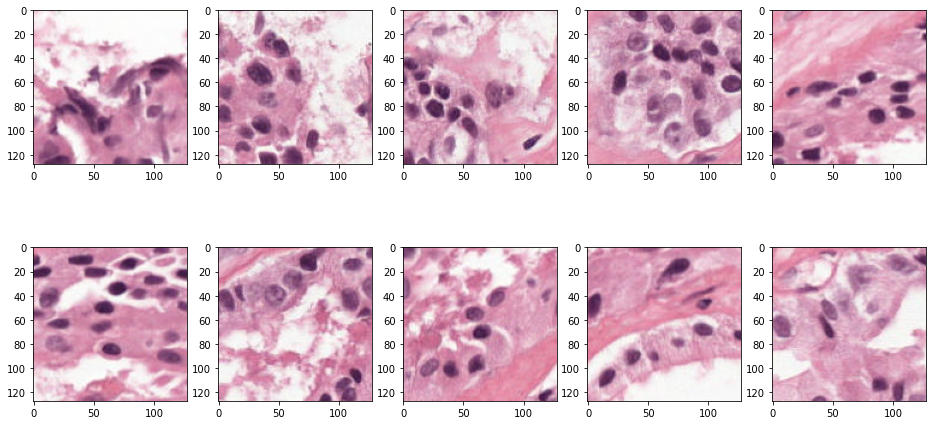

In [18]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)

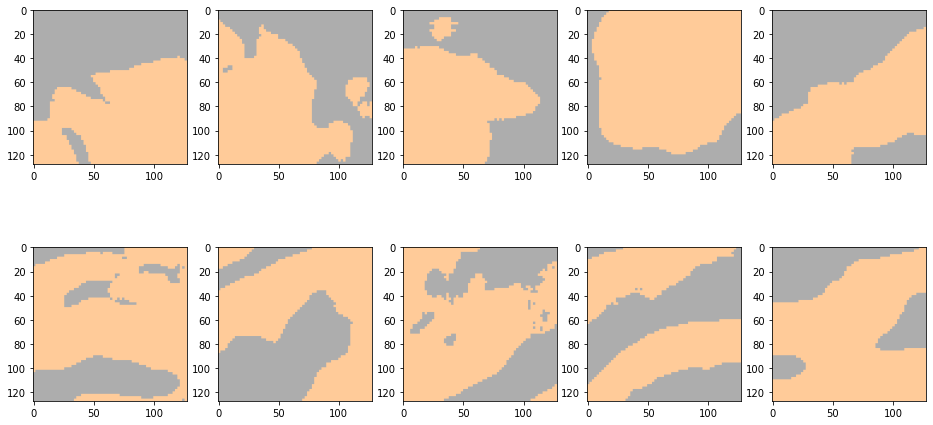

In [19]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(mask, alpha=0.4)

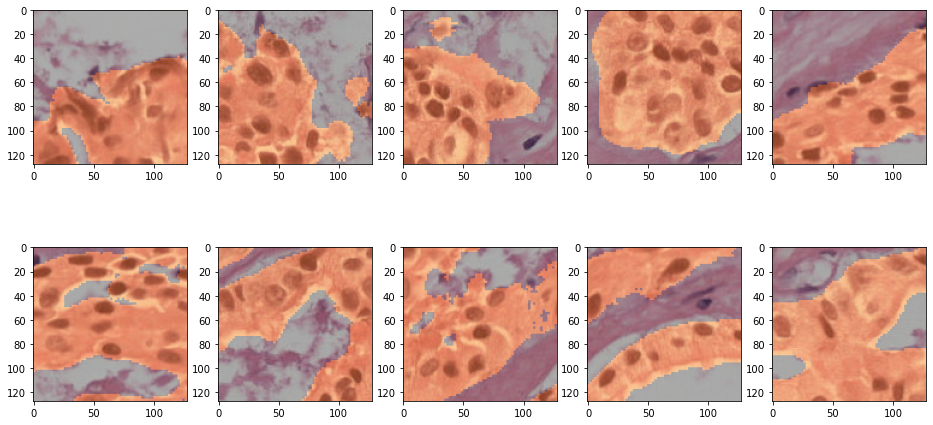

In [20]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)
    ax.imshow(mask, alpha=0.4)

---
## Gleason_Score: 5+4

In [21]:
%%time
target_id = '00ca0c23961b5510be46c917be11c43e'
SIZE = 128

res, img_list, mask_list = PANDA_Image_Preprocessing(target_id, SIZE, background_rate=0.5, saveimg=False)

Wall time: 42.9 s


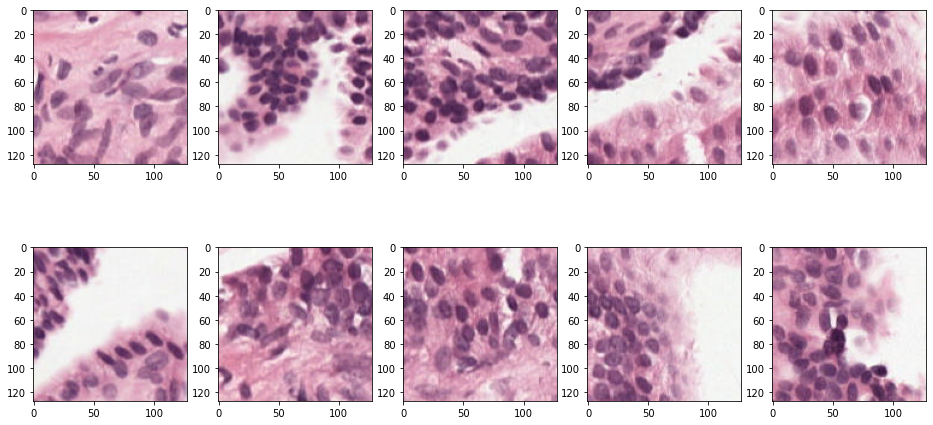

In [22]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)

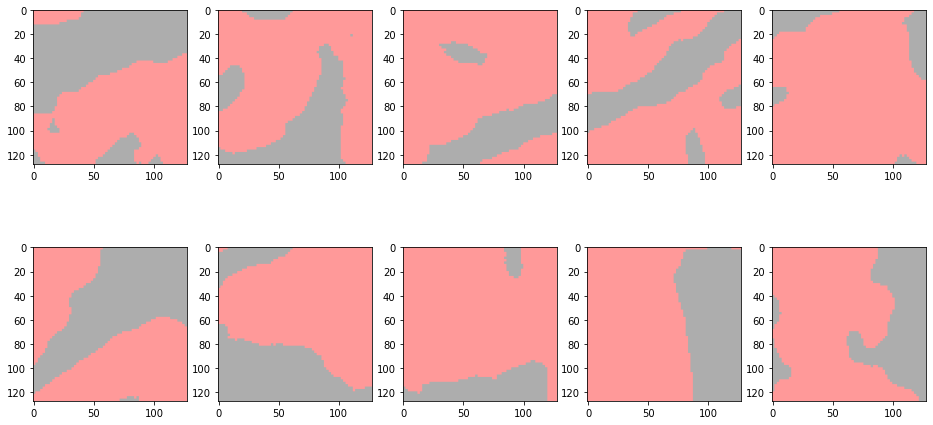

In [23]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(mask, alpha=0.4)

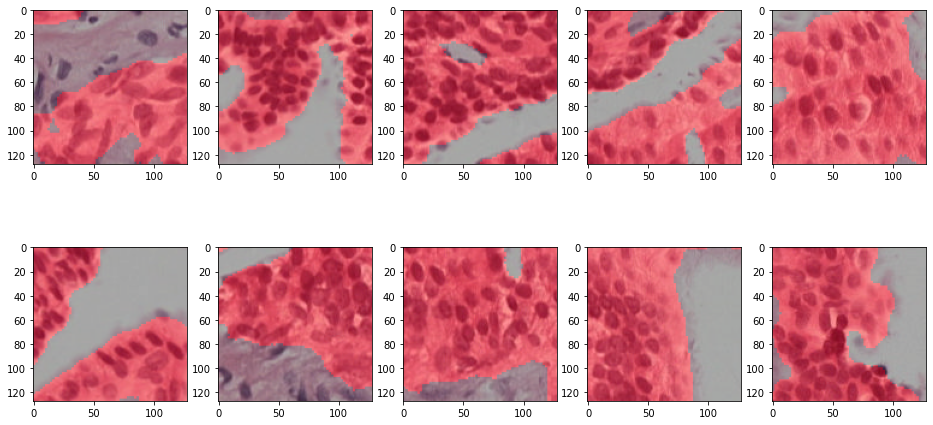

In [24]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(16, 8), facecolor='w')
for ax, img, mask in zip(axes.ravel(), img_list, mask_list):
    ax.imshow(img)
    ax.imshow(mask, alpha=0.4)

---

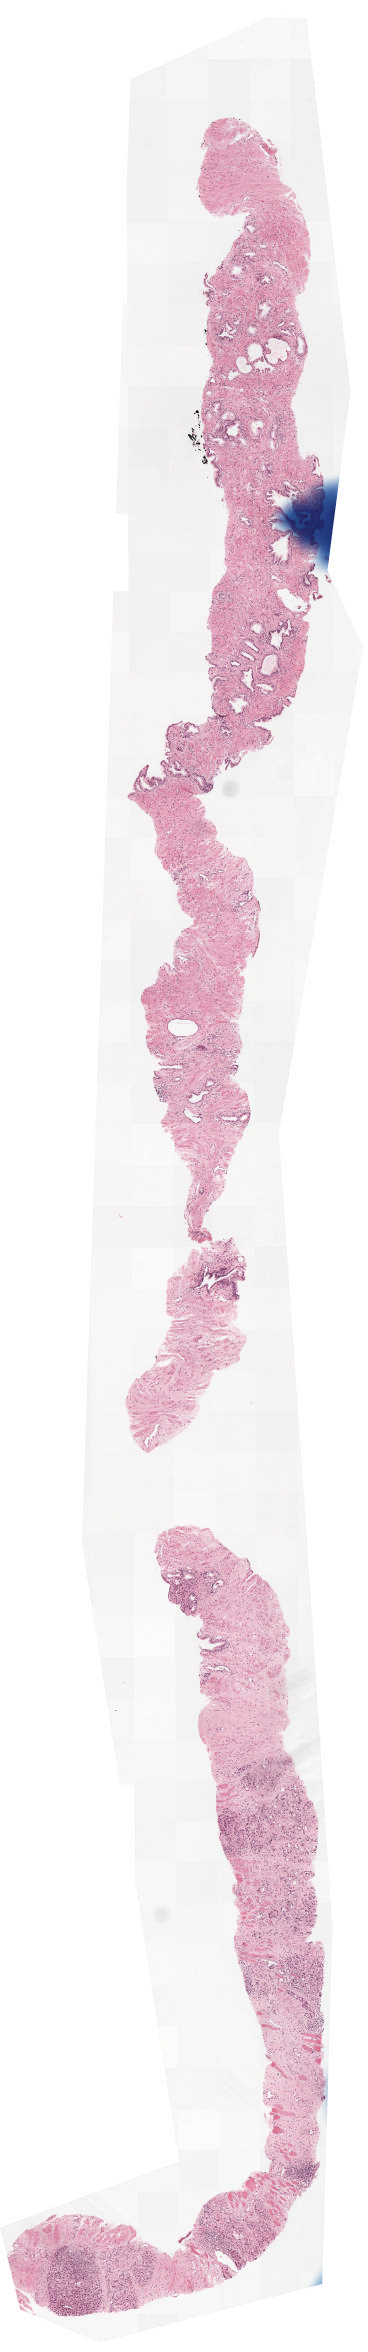

In [24]:
img = display_img(target_id, show_img=True, tiff_level=-1)

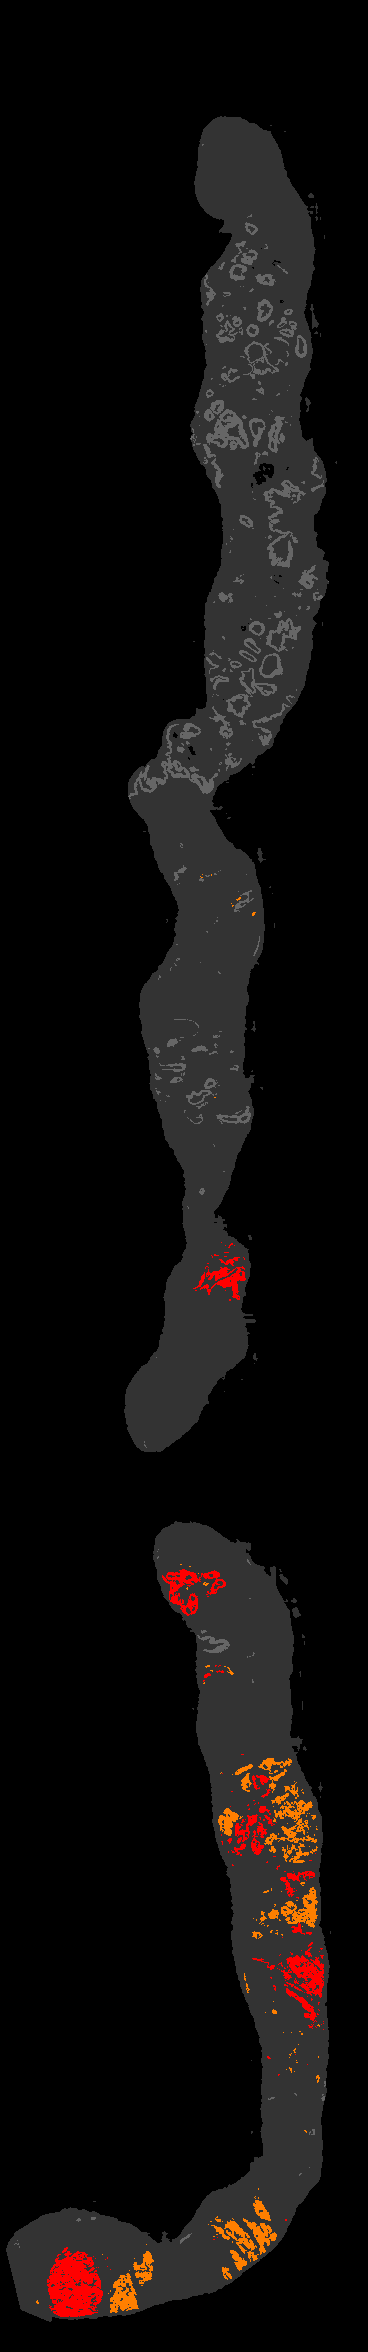

In [25]:
mask = display_mask(target_id, center='radboud', show_img=True, tiff_level=-1)

In [26]:
res.head()

score_0  score_3  score_4  score_5                              image_id
0      1.0      0.0      0.0      0.0  00ca0c23961b5510be46c917be11c43e_0_0
1      1.0      0.0      0.0      0.0  00ca0c23961b5510be46c917be11c43e_0_1
2      1.0      0.0      0.0      0.0  00ca0c23961b5510be46c917be11c43e_0_2
3      1.0      0.0      0.0      0.0  00ca0c23961b5510be46c917be11c43e_0_3
4      1.0      0.0      0.0      0.0  00ca0c23961b5510be46c917be11c43e_0_4